In [1]:
# Vakuutusriskin mallintaminen ja hinnoittelu
# Insurance Risk Modeling and Pricing Analytics


# Mitä tämä projekti tekee
# 1. Vakuutusmatematiikan perusteet:

# Claim Frequency (vahinkofrekvenssi) - Poisson-jakauma
# Claim Severity (vahinkosuuruus) - Log-normal jakauma
# Pure Premium (puhdas preemio) = Frequency × Severity
# Risk-based pricing (riskiperusteinen hinnoittelu)

# 2. Actuarial modeling:

# Poisson Regression vahinkofrekvenssin ennustamiseen
# Random Forest vahinkosuuruuden mallintamiseen
# Gradient Boosting kokonaisriskin arvioimiseen
# Feature engineering vakuutuskohtaisille muuttujille

# 3. Hinnoitteluanalyysi:

# Riskisegmentointi (Very Low → Extreme)
# Pure Premium + Loading factor (40%)
# Profitabiliteetin arviointi segmenteittäin
# Käytännön hinnoitteluesimerkit

# 4. Vakuutusalan visualisoinnit:

# Vahinkosummien jakauma
# Demografiset riskiprofiilit
# Alueiden ja ikäryhmien vertailu
# Feature importance analyysi

# Käytännön sovellutukset:

# Autovakuutukset - riskiperusteinen hinnoittelu
# Henki-/sairausvakuutukset - kuolleisuus/sairastuvuusmallintaminen
# Omaisuusvakuutukset - katastrofiriskin arviointi
# Vakuutusmatematikka - vakavaraisuuslaskelmat

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Matplotlib asetukset
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✅ Kirjastot ladattu onnistuneesti!")
print("🚗 Vakuutusriskin mallintaminen ja hinnoittelu - Valmis!")

✅ Kirjastot ladattu onnistuneesti!
🚗 Vakuutusriskin mallintaminen ja hinnoittelu - Valmis!


In [28]:
class InsuranceRiskAnalyzer:
    def __init__(self):
        self.claim_frequency_model = None
        self.claim_severity_model = None
        self.risk_score_model = None
        self.data = None
        self.processed_data = None
        print("🏗️ InsuranceRiskAnalyzer luotu!")

In [4]:
def generate_synthetic_data(self, n_policies=10000):
    """Luodaan synteettistä vakuutusdataa analyysiä varten"""
    print("🏗️ Luodaan synteettistä vakuutusdataa...")
    
    np.random.seed(42)
    
    # Perusdemografia
    ages = np.random.normal(45, 15, n_policies).clip(18, 80)
    genders = np.random.choice(['M', 'F'], n_policies, p=[0.52, 0.48])
    
    # Maantieteelliset tekijät
    regions = np.random.choice(['Helsinki', 'Tampere', 'Turku', 'Oulu', 'Jyväskylä'], 
                             n_policies, p=[0.3, 0.2, 0.2, 0.15, 0.15])
    
    # Ajoneuvotiedot (autovakuutus)
    vehicle_ages = np.random.exponential(8, n_policies).clip(0, 25)
    vehicle_values = np.random.lognormal(10, 0.8, n_policies).clip(5000, 200000)
    
    # Käyttötottumukset
    annual_mileage = np.random.lognormal(9.5, 0.5, n_policies).clip(5000, 50000)
    
    # Vakuutushistoria
    years_insured = np.random.exponential(5, n_policies).clip(0, 30)
    previous_claims = np.random.poisson(0.3, n_policies)
    
    # Riskitekijöiden painotukset
    age_risk = (ages < 25) * 0.5 + (ages > 70) * 0.3
    region_risk = pd.Series(regions).map({
        'Helsinki': 0.2, 'Tampere': 0.1, 'Turku': 0.1, 
        'Oulu': 0.05, 'Jyväskylä': 0.05
    }).values
    
    vehicle_risk = (vehicle_ages < 2) * 0.1 + (vehicle_ages > 15) * 0.2
    mileage_risk = (annual_mileage > 30000) * 0.15
    history_risk = previous_claims * 0.1
    
    # Kokonaisriski
    total_risk = age_risk + region_risk + vehicle_risk + mileage_risk + history_risk
    
    # Vahinkojen lukumäärä (Poisson-jakauma)
    claim_frequency = np.random.poisson(total_risk + 0.1, n_policies)
    
    # Vahingon suuruus (Log-normal jakauma kun vahinkoja)
    claims_data = []
    for i in range(n_policies):
        n_claims = claim_frequency[i]
        if n_claims > 0:
            # Vakavuus riippuu ajoneuvon arvosta ja muista tekijöistä
            severity_factor = np.log(vehicle_values[i]/20000) + total_risk[i]
            claim_amounts = np.random.lognormal(
                7 + severity_factor * 0.3, 1.2, n_claims
            ).clip(100, vehicle_values[i])
            total_claim_amount = claim_amounts.sum()
        else:
            total_claim_amount = 0
            
        claims_data.append({
            'policy_id': f'POL_{i:06d}',
            'age': ages[i],
            'gender': genders[i],
            'region': regions[i],
            'vehicle_age': vehicle_ages[i],
            'vehicle_value': vehicle_values[i],
            'annual_mileage': annual_mileage[i],
            'years_insured': years_insured[i],
            'previous_claims': previous_claims[i],
            'claim_count': claim_frequency[i],
            'total_claim_amount': total_claim_amount,
            'risk_score': total_risk[i]
        })
    
    self.data = pd.DataFrame(claims_data)
    
    # Lasketaan lisämittareita
    self.data['has_claim'] = (self.data['claim_count'] > 0).astype(int)
    self.data['claim_rate'] = self.data['claim_count'] / 1  # per vuosi
    self.data['avg_claim_amount'] = np.where(
        self.data['claim_count'] > 0,
        self.data['total_claim_amount'] / self.data['claim_count'],
        0
    )
    
    print(f"✅ Luotu {len(self.data)} vakuutusta")
    print(f"   Vahinkoja yhteensä: {self.data['claim_count'].sum()}")
    print(f"   Vahinko-%: {self.data['has_claim'].mean():.1%}")
    print(f"   Keskimääräinen vahinkosumma: {self.data['total_claim_amount'].mean():.0f}€")
    
    return self.data

InsuranceRiskAnalyzer.generate_synthetic_data = generate_synthetic_data

In [5]:
def exploratory_analysis(self):
    """Suoritetaan kattava EDA vakuutusdatalle"""
    print("\n" + "="*60)
    print("📊 VAKUUTUSDATAN EKSPLORATIIVINEN ANALYYSI")
    print("="*60)
    
    # Perustilastot
    print("\n📈 VAHINKOTILASTOT:")
    print(f"Vakuutusten määrä: {len(self.data):,}")
    print(f"Vahinkojen määrä: {self.data['claim_count'].sum():,}")
    print(f"Vahinko-% (frequency): {self.data['has_claim'].mean():.2%}")
    print(f"Keskimääräinen vahinkosumma: {self.data['total_claim_amount'].mean():.0f}€")
    print(f"Mediaani vahinkosumma: {self.data['total_claim_amount'].median():.0f}€")
    print(f"Maksimi vahinkosumma: {self.data['total_claim_amount'].max():.0f}€")
    
    # Pure Premium (odotettu vahinkokustannus)
    pure_premium = self.data['total_claim_amount'].mean()
    print(f"Pure Premium (expected cost): {pure_premium:.0f}€")
    
    # Loss Ratio -analyysi (oletetaan 800€ keskimääräinen preemio)
    assumed_premium = 800
    loss_ratio = pure_premium / assumed_premium
    print(f"Loss Ratio (@ {assumed_premium}€ premium): {loss_ratio:.1%}")
    
    return self.data.describe()

InsuranceRiskAnalyzer.exploratory_analysis = exploratory_analysis

In [6]:
def demographic_analysis(self):
        """Analysoidaan demografisten tekijöiden vaikutusta riskiin"""
        print("\n📊 DEMOGRAFINEN RISKIANALYYSI:")
        print("-" * 40)
        
        # Ikäryhmäanalyysi
        age_groups = pd.cut(self.data['age'], bins=[18, 25, 35, 50, 65, 80], 
                           labels=['18-25', '26-35', '36-50', '51-65', '66-80'])
        age_risk = self.data.groupby(age_groups).agg({
            'has_claim': 'mean',
            'claim_count': 'mean', 
            'total_claim_amount': 'mean'
        }).round(3)
        
        print("IKÄ:")
        print(age_risk)
        
        # Sukupuolianalyysi
        gender_risk = self.data.groupby('gender').agg({
            'has_claim': 'mean',
            'claim_count': 'mean',
            'total_claim_amount': 'mean'
        }).round(3)
        
        print("\nSUKUPUOLI:")
        print(gender_risk)
        
        # Alueanalyysi
        region_risk = self.data.groupby('region').agg({
            'has_claim': 'mean',
            'claim_count': 'mean',
            'total_claim_amount': 'mean'
        }).round(3)
        
        print("\nALUE:")
        print(region_risk)
        
        return age_risk, gender_risk, region_risk

InsuranceRiskAnalyzer.demographic_analysis = demographic_analysis

In [7]:
def prepare_modeling_data(self):
    """Valmistellaan data mallintamiseen"""
    print("\n🔧 FEATURE ENGINEERING:")
    print("-" * 30)
    
    # Valmistellaan data mallintamiseen
    self.processed_data = self.data.copy()
    
    # Encode categorical variables
    le_gender = LabelEncoder()
    le_region = LabelEncoder()
    
    self.processed_data['gender_encoded'] = le_gender.fit_transform(self.processed_data['gender'])
    self.processed_data['region_encoded'] = le_region.fit_transform(self.processed_data['region'])
    
    # Feature engineering
    self.processed_data['age_squared'] = self.processed_data['age'] ** 2
    self.processed_data['vehicle_age_log'] = np.log1p(self.processed_data['vehicle_age'])
    self.processed_data['mileage_log'] = np.log(self.processed_data['annual_mileage'])
    self.processed_data['experience_factor'] = np.exp(-self.processed_data['years_insured'] / 10)
    self.processed_data['value_per_age'] = self.processed_data['vehicle_value'] / (self.processed_data['vehicle_age'] + 1)
    
    # Mallinnusfeaturet
    self.feature_cols = [
        'age', 'age_squared', 'gender_encoded', 'region_encoded',
        'vehicle_age', 'vehicle_age_log', 'vehicle_value', 
        'annual_mileage', 'mileage_log', 'years_insured', 
        'previous_claims', 'experience_factor', 'value_per_age'
    ]
    
    print(f"✅ Feature engineering valmis!")
    print(f"   Käytettävät featuret: {len(self.feature_cols)}")
    print(f"   Featuret: {', '.join(self.feature_cols)}")
    
    return self.processed_data

InsuranceRiskAnalyzer.prepare_modeling_data = prepare_modeling_data

In [8]:
def model_claim_frequency(self):
    """Mallinnetaan vahinkofrekvenssi Poisson-regressiolla"""
    print("\n1️⃣ VAHINKOFREKVENSSIN MALLINTAMINEN (Poisson):")
    print("-" * 50)
    
    if self.processed_data is None:
        print("❌ Suorita ensin prepare_modeling_data()!")
        return None
    
    X = self.processed_data[self.feature_cols]
    y_freq = self.processed_data['claim_count']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_freq, test_size=0.2, random_state=42
    )
    
    # Poisson regression
    self.claim_frequency_model = PoissonRegressor(alpha=0.1, max_iter=1000)
    self.claim_frequency_model.fit(X_train, y_train)
    
    # Ennusteet ja arviointi
    freq_pred_train = self.claim_frequency_model.predict(X_train)
    freq_pred_test = self.claim_frequency_model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, freq_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, freq_pred_test))
    
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Mean actual frequency (test): {y_test.mean():.4f}")
    print(f"Mean predicted frequency (test): {freq_pred_test.mean():.4f}")
    
    # Residuaalien analyysi
    residuals = y_test - freq_pred_test
    print(f"Residuaalien keskiarvo: {residuals.mean():.4f}")
    print(f"Residuaalien keskihajonta: {residuals.std():.4f}")
    
    return {
        'model': self.claim_frequency_model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'predictions_test': freq_pred_test,
        'actual_test': y_test
    }

InsuranceRiskAnalyzer.model_claim_frequency = model_claim_frequency

In [9]:
def model_claim_severity(self):
    """Mallinnetaan vahinkosuuruus Random Forest -mallilla"""
    print("\n2️⃣ VAHINKOSUURUUDEN MALLINTAMINEN (Random Forest):")
    print("-" * 50)
    
    if self.processed_data is None:
        print("❌ Suorita ensin prepare_modeling_data()!")
        return None
    
    # Otetaan vain ne, joilla vahinkoja
    severity_data = self.processed_data[self.processed_data['total_claim_amount'] > 0].copy()
    
    if len(severity_data) < 100:
        print(f"❌ Liian vähän vahinkoja mallintamiseen: {len(severity_data)}")
        return None
    
    print(f"📊 Mallinnusaineisto: {len(severity_data)} vahinkotapausta")
    
    X_sev = severity_data[self.feature_cols]
    y_sev = severity_data['total_claim_amount']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_sev, y_sev, test_size=0.2, random_state=42
    )
    
    # Random Forest severity-mallille
    self.claim_severity_model = RandomForestRegressor(
        n_estimators=200, 
        random_state=42, 
        max_depth=12,
        min_samples_split=10,
        min_samples_leaf=5
    )
    self.claim_severity_model.fit(X_train, y_train)
    
    # Ennusteet ja arviointi
    sev_pred_train = self.claim_severity_model.predict(X_train)
    sev_pred_test = self.claim_severity_model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, sev_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, sev_pred_test))
    train_r2 = r2_score(y_train, sev_pred_train)
    test_r2 = r2_score(y_test, sev_pred_test)
    
    print(f"Train RMSE: {train_rmse:.0f}€")
    print(f"Test RMSE: {test_rmse:.0f}€")
    print(f"Train R²: {train_r2:.3f}")
    print(f"Test R²: {test_r2:.3f}")
    print(f"Mean actual severity (test): {y_test.mean():.0f}€")
    print(f"Mean predicted severity (test): {sev_pred_test.mean():.0f}€")
    
    return {
        'model': self.claim_severity_model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'predictions_test': sev_pred_test,
        'actual_test': y_test
    }

InsuranceRiskAnalyzer.model_claim_severity = model_claim_severity

In [10]:
def model_total_risk(self):
    """Mallinnetaan kokonaisriski Gradient Boosting -mallilla"""
    print("\n3️⃣ KOKONAISRISKIN MALLINTAMINEN (Gradient Boosting):")
    print("-" * 50)
    
    if self.processed_data is None:
        print("❌ Suorita ensin prepare_modeling_data()!")
        return None
    
    X = self.processed_data[self.feature_cols]
    y_risk = self.processed_data['total_claim_amount']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_risk, test_size=0.2, random_state=42
    )
    
    # Gradient Boosting kokonaisriskille
    self.risk_score_model = GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=8,
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.8,
        random_state=42
    )
    self.risk_score_model.fit(X_train, y_train)
    
    # Ennusteet ja arviointi
    risk_pred_train = self.risk_score_model.predict(X_train)
    risk_pred_test = self.risk_score_model.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, risk_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, risk_pred_test))
    train_r2 = r2_score(y_train, risk_pred_train)
    test_r2 = r2_score(y_test, risk_pred_test)
    
    print(f"Train RMSE: {train_rmse:.0f}€")
    print(f"Test RMSE: {test_rmse:.0f}€")
    print(f"Train R²: {train_r2:.3f}")
    print(f"Test R²: {test_r2:.3f}")
    print(f"Mean actual risk (test): {y_test.mean():.0f}€")
    print(f"Mean predicted risk (test): {risk_pred_test.mean():.0f}€")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'Feature': self.feature_cols,
        'Importance': self.risk_score_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTOP 5 TÄRKEINTÄ RISKITEKIJÄÄ:")
    for i, row in feature_importance.head(5).iterrows():
        print(f"   {row['Feature']:20}: {row['Importance']:.3f}")
    
    return {
        'model': self.risk_score_model,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'feature_importance': feature_importance,
        'predictions_test': risk_pred_test,
        'actual_test': y_test
    }

InsuranceRiskAnalyzer.model_total_risk = model_total_risk

In [11]:
def pricing_analysis(self):
    """Suoritetaan hinnoitteluanalyysi eri riskisegmenteille"""
    print("\n💰 HINNOITTELUANALYYSI:")
    print("-" * 40)
    
    if self.risk_score_model is None:
        print("❌ Suorita ensin model_total_risk()!")
        return None
    
    # riskit koko aineistolle
    X = self.processed_data[self.feature_cols]
    predicted_risk = self.risk_score_model.predict(X)
    
    # riskisegmentit
    risk_percentiles = [0, 20, 40, 60, 80, 95, 100]
    risk_segments = pd.cut(predicted_risk, 
                          bins=np.percentile(predicted_risk, risk_percentiles),
                          labels=['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extreme'])
    
    # Analysoidaan segmentit
    pricing_analysis = pd.DataFrame({
        'Segment': risk_segments,
        'Actual_Cost': self.processed_data['total_claim_amount'],
        'Predicted_Risk': predicted_risk,
        'Count': 1,
        'Has_Claim': self.processed_data['has_claim']
    }).groupby('Segment').agg({
        'Count': 'sum',
        'Actual_Cost': ['mean', 'std', 'median'],
        'Predicted_Risk': ['mean', 'std'],
        'Has_Claim': 'mean'
    }).round(0)
    
    pricing_analysis.columns = ['Count', 'Actual_Mean', 'Actual_Std', 'Actual_Median', 
                               'Predicted_Mean', 'Predicted_Std', 'Claim_Rate']
    
    # Ehdotettu hinnoittelu (Pure Premium + 40% loading)
    loading_factor = 1.4
    pricing_analysis['Suggested_Premium'] = pricing_analysis['Predicted_Mean'] * loading_factor
    pricing_analysis['Expected_Profit_Margin'] = (
        pricing_analysis['Suggested_Premium'] - pricing_analysis['Actual_Mean']
    ) / pricing_analysis['Suggested_Premium']
    
    print("RISKISEGMENTTI-ANALYYSI:")
    print("=" * 80)
    print(pricing_analysis)
    
    # Kokonaismarginaali
    total_premium = (pricing_analysis['Suggested_Premium'] * pricing_analysis['Count']).sum()
    total_claims = (pricing_analysis['Actual_Mean'] * pricing_analysis['Count']).sum()
    overall_margin = (total_premium - total_claims) / total_premium
    
    print(f"\n📊 KOKONAISPROFITABILITEETTI:")
    print(f"Odotettu kokonaismarginaali: {overall_margin:.1%}")
    print(f"Keskimääräinen preemio: {total_premium/pricing_analysis['Count'].sum():.0f}€")
    print(f"Loading factor: {(loading_factor-1)*100:.0f}%")
    
    # Tallennetaan segmenttianalyysi
    self.pricing_segments = pricing_analysis
    
    return pricing_analysis

InsuranceRiskAnalyzer.pricing_analysis = pricing_analysis

In [12]:
def create_basic_visualizations(self):
    """Luodaan perusvisualisoinnit vakuutusdatalle"""
    print("\n📊 Luodaan perusvisualisoinnit...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Vahinkojen jakauma
    claim_amounts = self.data[self.data['total_claim_amount'] > 0]['total_claim_amount']
    axes[0,0].hist(claim_amounts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Vahinkosummien jakauma (vain vahingot)', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Vahinkosumma (€)')
    axes[0,0].set_ylabel('Frekvenssi')
    axes[0,0].axvline(claim_amounts.mean(), color='red', linestyle='--', 
                     label=f'Keskiarvo: {claim_amounts.mean():.0f}€')
    axes[0,0].axvline(claim_amounts.median(), color='orange', linestyle='--', 
                     label=f'Mediaani: {claim_amounts.median():.0f}€')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Vahinkofrekvenssin jakauma
    claim_counts = self.data['claim_count']
    unique_counts = sorted(claim_counts.unique())
    count_freq = [np.mean(claim_counts == count) for count in unique_counts]
    
    axes[0,1].bar(unique_counts, count_freq, alpha=0.7, color='lightcoral')
    axes[0,1].set_title('Vahinkofrekvenssin jakauma', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Vahinkojen lukumäärä per vakuutus')
    axes[0,1].set_ylabel('Todennäköisyys')
    axes[0,1].grid(True, alpha=0.3)
    
    # Lisätään prosentit pylväiden päälle
    for i, (count, freq) in enumerate(zip(unique_counts, count_freq)):
        axes[0,1].text(count, freq + 0.01, f'{freq:.1%}', ha='center', va='bottom')
    
    # 3. Ikä vs. riski scatter plot
    axes[1,0].scatter(self.data['age'], self.data['total_claim_amount'], 
                     alpha=0.5, s=30, color='green')
    axes[1,0].set_title('Ikä vs. Vahinkosumma', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Ikä (vuotta)')
    axes[1,0].set_ylabel('Vahinkosumma (€)')
    axes[1,0].grid(True, alpha=0.3)
    
    # Lisätään trendilinja
    z = np.polyfit(self.data['age'], self.data['total_claim_amount'], 1)
    p = np.poly1d(z)
    axes[1,0].plot(self.data['age'], p(self.data['age']), "r--", alpha=0.8, linewidth=2)
    
    # 4. Ajoneuvon arvo vs. riski
    axes[1,1].scatter(self.data['vehicle_value'], self.data['total_claim_amount'], 
                     alpha=0.5, s=30, color='purple')
    axes[1,1].set_title('Ajoneuvon arvo vs. Vahinkosumma', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Ajoneuvon arvo (€)')
    axes[1,1].set_ylabel('Vahinkosumma (€)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

InsuranceRiskAnalyzer.create_basic_visualizations = create_basic_visualizations

In [13]:
def create_demographic_visualizations(self):
    """Luodaan demografiset visualisoinnit"""
    print("\n📊 Luodaan demografiset visualisoinnit...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Ikäryhmäanalyysi
    age_groups = pd.cut(self.data['age'], bins=[18, 25, 35, 50, 65, 80], 
                       labels=['18-25', '26-35', '36-50', '51-65', '66-80'])
    age_risk = self.data.groupby(age_groups).agg({
        'total_claim_amount': 'mean',
        'has_claim': 'mean'
    })
    
    ax1 = axes[0,0]
    ax1_twin = ax1.twinx()
    
    bars1 = ax1.bar(range(len(age_risk)), age_risk['total_claim_amount'], 
                   alpha=0.7, color='lightcoral', label='Keskimääräinen vahinkosumma')
    line1 = ax1_twin.plot(range(len(age_risk)), age_risk['has_claim']*100, 
                         'bo-', color='darkblue', label='Vahinko-% (oikea akseli)')
    
    ax1.set_title('Riski ikäryhmittäin', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Ikäryhmä')
    ax1.set_ylabel('Keskimääräinen vahinkosumma (€)', color='red')
    ax1_twin.set_ylabel('Vahinko-% ', color='blue')
    ax1.set_xticks(range(len(age_risk)))
    ax1.set_xticklabels(age_risk.index, rotation=45)
    
    # Lisätään arvot pylväisiin
    for i, value in enumerate(age_risk['total_claim_amount']):
        ax1.text(i, value + 50, f'{value:.0f}€', ha='center', va='bottom')
    
    # 2. Alueiden vertailu
    region_stats = self.data.groupby('region').agg({
        'total_claim_amount': 'mean',
        'has_claim': 'mean',
        'claim_count': 'mean'
    })
    
    bars = axes[0,1].bar(region_stats.index, region_stats['total_claim_amount'], 
                       color='lightgreen', alpha=0.8)
    axes[0,1].set_title('Keskimääräinen vahinkosumma alueittain', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Vahinkosumma (€)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Lisää arvot pylväiden päälle
    for bar, value in zip(bars, region_stats['total_claim_amount']):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                      f'{value:.0f}€', ha='center', va='bottom')
    
    # 3. Sukupuoli vs. riski
    gender_stats = self.data.groupby('gender').agg({
        'total_claim_amount': ['mean', 'std'],
        'has_claim': 'mean'
    })
    gender_stats.columns = ['Mean_Amount', 'Std_Amount', 'Claim_Rate']
    
    x_pos = np.arange(len(gender_stats))
    bars = axes[1,0].bar(x_pos, gender_stats['Mean_Amount'], 
                        yerr=gender_stats['Std_Amount'], 
                        alpha=0.7, color=['lightblue', 'pink'], 
                        capsize=5)
    axes[1,0].set_title('Sukupuoli vs. Vahinkosumma', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Sukupuoli')
    axes[1,0].set_ylabel('Keskimääräinen vahinkosumma (€)')
    axes[1,0].set_xticks(x_pos)
    axes[1,0].set_xticklabels(gender_stats.index)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Ajoneuvon ikä vs. riski
    vehicle_age_bins = pd.cut(self.data['vehicle_age'], bins=[0, 2, 5, 10, 15, 25], 
                             labels=['0-2v', '2-5v', '5-10v', '10-15v', '15v+'])
    vehicle_risk = self.data.groupby(vehicle_age_bins)['total_claim_amount'].mean()
    
    bars = axes[1,1].bar(range(len(vehicle_risk)), vehicle_risk.values, 
                        color='orange', alpha=0.8)
    axes[1,1].set_title('Riski ajoneuvon iän mukaan', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Ajoneuvon ikä')
    axes[1,1].set_ylabel('Keskimääräinen vahinkosumma (€)')
    axes[1,1].set_xticks(range(len(vehicle_risk)))
    axes[1,1].set_xticklabels(vehicle_risk.index, rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

InsuranceRiskAnalyzer.create_demographic_visualizations = create_demographic_visualizations

In [14]:
def create_model_performance_visualizations(self):
    """Luodaan mallien suorituskyvyn visualisoinnit"""
    if self.risk_score_model is None:
        print("❌ Malleja ei ole koulutettu! Suorita ensin mallintaminen.")
        return
    
    print("\n📊 Luodaan mallien suorituskyvyn visualisoinnit...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Feature importance
    feature_importance = pd.DataFrame({
        'Feature': self.feature_cols,
        'Importance': self.risk_score_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    
    bars = axes[0,0].barh(range(len(feature_importance)), feature_importance['Importance'], 
                         color='purple', alpha=0.7)
    axes[0,0].set_yticks(range(len(feature_importance)))
    axes[0,0].set_yticklabels(feature_importance['Feature'])
    axes[0,0].set_title('Top 10 tärkeintä riskitekijää', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Feature Importance')
    
    # Lisätään arvot pylväiden viereen
    for i, (bar, value) in enumerate(zip(bars, feature_importance['Importance'])):
        axes[0,0].text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                      f'{value:.3f}', ha='left', va='center')
    
    # 2. Ennustettu vs. todellinen riski
    X = self.processed_data[self.feature_cols]
    predicted_risk = self.risk_score_model.predict(X)
    actual_risk = self.processed_data['total_claim_amount']
    
    axes[0,1].scatter(predicted_risk, actual_risk, alpha=0.5, s=20)
    axes[0,1].plot([0, max(predicted_risk)], [0, max(predicted_risk)], 'r--', alpha=0.8)
    axes[0,1].set_title('Ennustettu vs. Todellinen riski', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Ennustettu riski (€)')
    axes[0,1].set_ylabel('Todellinen riski (€)')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Residuaalit
    residuals = actual_risk - predicted_risk
    axes[1,0].scatter(predicted_risk, residuals, alpha=0.5, s=20)
    axes[1,0].axhline(y=0, color='r', linestyle='--')
    axes[1,0].set_title('Residuaalien jakautuminen', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Ennustettu riski (€)')
    axes[1,0].set_ylabel('Residuaalit (€)')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Riskisegmenttien jakauma
    if hasattr(self, 'pricing_segments'):
        segments = self.pricing_segments.index
        counts = self.pricing_segments['Count']
        
        colors = ['green', 'lightgreen', 'yellow', 'orange', 'red', 'darkred']
        bars = axes[1,1].bar(segments, counts, color=colors[:len(segments)], alpha=0.8)
        axes[1,1].set_title('Asiakkaiden jakauma riskisegmenteissä', fontsize=14, fontweight='bold')
        axes[1,1].set_xlabel('Riskisegmentti')
        axes[1,1].set_ylabel('Asiakkaiden määrä')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        # Lisää prosentit
        total_customers = counts.sum()
        for bar, count in zip(bars, counts):
            pct = count / total_customers * 100
            axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                          f'{pct:.1f}%', ha='center', va='bottom')
    else:
        axes[1,1].text(0.5, 0.5, 'Hinnoitteluanalyysi puuttuu\nSuorita pricing_analysis()', 
                      ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)
        axes[1,1].set_title('Riskisegmentit', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

InsuranceRiskAnalyzer.create_model_performance_visualizations = create_model_performance_visualizations

In [15]:
def create_pricing_visualizations(self):
    """Luodaan hinnoitteluun liittyvät visualisoinnit"""
    if not hasattr(self, 'pricing_segments'):
        print("❌ Hinnoitteluanalyysi puuttuu! Suorita ensin pricing_analysis().")
        return
    
    print("\n📊 Luodaan hinnoitteluvisualisoinnit...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Ehdotetut preemiot vs. todelliset kustannukset
    segments = self.pricing_segments.index
    actual_costs = self.pricing_segments['Actual_Mean']
    suggested_premiums = self.pricing_segments['Suggested_Premium']
    
    x = np.arange(len(segments))
    width = 0.35
    
    bars1 = axes[0,0].bar(x - width/2, actual_costs, width, label='Todelliset kustannukset', 
                         color='red', alpha=0.7)
    bars2 = axes[0,0].bar(x + width/2, suggested_premiums, width, label='Ehdotetut preemiot', 
                         color='green', alpha=0.7)
    
    axes[0,0].set_title('Kustannukset vs. Ehdotetut preemiot', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel('Riskisegmentti')
    axes[0,0].set_ylabel('Summa (€)')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(segments, rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Voittomarginaalit segmenteittäin
    margins = self.pricing_segments['Expected_Profit_Margin'] * 100
    colors = ['red' if m < 10 else 'orange' if m < 25 else 'green' for m in margins]
    
    bars = axes[0,1].bar(segments, margins, color=colors, alpha=0.8)
    axes[0,1].set_title('Odotetut voittomarginaalit', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Riskisegmentti')
    axes[0,1].set_ylabel('Voittomarginaali (%)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].axhline(y=20, color='black', linestyle='--', alpha=0.5, label='Tavoite 20%')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Lisää arvot pylväisiin
    for bar, margin in zip(bars, margins):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                      f'{margin:.1f}%', ha='center', va='bottom')
    
    # 3. Vahinko-% vs. ehdotettu preemio
    claim_rates = self.pricing_segments['Claim_Rate'] * 100
    
    axes[1,0].scatter(suggested_premiums, claim_rates, s=self.pricing_segments['Count']/10, 
                     alpha=0.7, c=range(len(segments)), cmap='viridis')
    axes[1,0].set_title('Ehdotettu preemio vs. Vahinko-%', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Ehdotettu preemio (€)')
    axes[1,0].set_ylabel('Vahinko-% (%)')
    axes[1,0].grid(True, alpha=0.3)
    
    # Lisätään segmenttien nimet
    for i, (premium, rate, segment) in enumerate(zip(suggested_premiums, claim_rates, segments)):
        axes[1,0].annotate(segment, (premium, rate), xytext=(5, 5), 
                          textcoords='offset points', fontsize=9)
    
    # 4. Kustannusten jakautuminen
    total_costs = actual_costs * self.pricing_segments['Count']
    total_premiums = suggested_premiums * self.pricing_segments['Count']
    
    # Pie chart kustannuksista
    axes[1,1].pie(total_costs, labels=segments, autopct='%1.1f%%', startangle=90)
    axes[1,1].set_title('Odotettujen kustannusten jakautuminen', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Tulostetaan yhteenveto
    total_revenue = total_premiums.sum()
    total_cost = total_costs.sum()
    overall_margin = (total_revenue - total_cost) / total_revenue * 100
    
    print(f"\n💰 HINNOITTELUN YHTEENVETO:")
    print(f"Kokonaistuotto (preemiot): {total_revenue:,.0f}€")
    print(f"Kokonaiskustannukset: {total_cost:,.0f}€")
    print(f"Odotettu voitto: {total_revenue - total_cost:,.0f}€")
    print(f"Kokonaismarginaali: {overall_margin:.1f}%")

InsuranceRiskAnalyzer.create_pricing_visualizations = create_pricing_visualizations

In [16]:
def generate_comprehensive_report(self):
    """Luodaan kattava vakuutusraportti"""
    print("\n" + "="*80)
    print("📋 VAKUUTUSRISKIN ANALYYSIRAPORTTI")
    print("="*80)
    
    # Yleiskatsaus
    print(f"\n📊 YLEISKATSAUS:")
    print(f"Analysoitu aineisto: {len(self.data):,} vakuutusta")
    print(f"Tarkastelujakso: 1 vuosi")
    print(f"Vakuutustyyppi: Autovakuutus")
    
    # Keskeiset tunnusluvut
    claim_freq = self.data['has_claim'].mean()
    avg_severity = self.data[self.data['total_claim_amount'] > 0]['total_claim_amount'].mean()
    pure_premium = self.data['total_claim_amount'].mean()
    
    print(f"\n🔢 KESKEISET TUNNUSLUVUT:")
    print(f"Vahinkofrekvenssi: {claim_freq:.2%}")
    print(f"Keskimääräinen vahinkosuuruus: {avg_severity:.0f}€")
    print(f"Pure Premium: {pure_premium:.0f}€")
    
    # Mallien suorituskyky
    if self.risk_score_model is not None:
        X = self.processed_data[self.feature_cols]
        y_true = self.processed_data['total_claim_amount']
        y_pred = self.risk_score_model.predict(X)
        
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        
        print(f"\n🤖 MALLIEN SUORITUSKYKY:")
        print(f"Kokonaisriskin RMSE: {rmse:.0f}€")
        print(f"Kokonaisriskin R²: {r2:.3f}")
        print(f"Keskimääräinen ennustevirhe: {np.mean(np.abs(y_true - y_pred)):.0f}€")
    
    # Riskianalyysi
    high_risk_threshold = self.data['total_claim_amount'].quantile(0.9)
    high_risk_count = (self.data['total_claim_amount'] > high_risk_threshold).sum()
    
    print(f"\n⚠️ RISKIANALYYSI:")
    print(f"Korkean riskin asiakkaita (top 10%): {high_risk_count:,}")
    print(f"Korkean riskin kynnys: {high_risk_threshold:.0f}€")
    print(f"Maksimi vahinkosumma: {self.data['total_claim_amount'].max():.0f}€")
    
    # Demografiset havainnot
    print(f"\n👥 DEMOGRAFISET HAVAINNOT:")
    
    # Ikäanalyysi
    young_drivers = self.data[self.data['age'] < 25]
    old_drivers = self.data[self.data['age'] > 65]
    
    print(f"Nuoret kuljettajat (<25v):")
    print(f"  - Osuus: {len(young_drivers)/len(self.data):.1%}")
    print(f"  - Keskimääräinen riski: {young_drivers['total_claim_amount'].mean():.0f}€")
    print(f"  - Vahinko-%: {young_drivers['has_claim'].mean():.1%}")
    
    print(f"Ikääntyneet kuljettajat (>65v):")
    print(f"  - Osuus: {len(old_drivers)/len(self.data):.1%}")
    print(f"  - Keskimääräinen riski: {old_drivers['total_claim_amount'].mean():.0f}€")
    print(f"  - Vahinko-%: {old_drivers['has_claim'].mean():.1%}")
    
    # Hinnoittelusuositukset
    loading_factor = 1.4  # 40% loading
    suggested_premium = pure_premium * loading_factor
    
    print(f"\n💰 HINNOITTELUSUOSITUKSET:")
    print(f"Suositeltu peruspreemio: {suggested_premium:.0f}€")
    print(f"Loading factor: {(loading_factor-1)*100:.0f}%")
    print(f"Odotettu voittomarginaali: {((suggested_premium-pure_premium)/suggested_premium)*100:.1f}%")
    
    # Riskisegmentti-analyysi
    if hasattr(self, 'pricing_segments'):
        print(f"\n📊 RISKISEGMENTOINTI:")
        print("=" * 60)
        
        for segment in self.pricing_segments.index:
            row = self.pricing_segments.loc[segment]
            print(f"\n{segment} RISKI:")
            print(f"  - Asiakkaita: {row['Count']:.0f} ({row['Count']/self.pricing_segments['Count'].sum()*100:.1f}%)")
            print(f"  - Keskimääräinen kustannus: {row['Actual_Mean']:.0f}€")
            print(f"  - Ehdotettu preemio: {row['Suggested_Premium']:.0f}€")
            print(f"  - Odotettu marginaali: {row['Expected_Profit_Margin']*100:.1f}%")
    
    # Suositukset
    print(f"\n🎯 LIIKETOIMINTASUOSITUKSET:")
    print("1. Implementoi riskiperusteinen hinnoittelu:")
    print("   • Nuoret kuljettajat: +30-50% preemioon")
    print("   • Helsinki-alue: +15-25% preemioon")
    print("   • Korkean kilometrimäärän kuljettajat: +10-20%")
    
    print("\n2. Riskinhallinta:")
    print("   • Vaadi telematiikka >25v kuljettajilta")
    print("   • Tarjoa alennuksia turvallisille kuljettajille")
    print("   • Seuraa erityisesti 'Extreme' riskiryhmää")
    
    print("\n3. Tuotekehitys:")
    print("   • Kehitä Usage-Based Insurance (UBI)")
    print("   • Tarjoa bonus-malus -järjestelmä")
    print("   • Harkitse kilometeripohjaista hinnoittelua")
    
    print("\n4. Kannattavuuden parantaminen:")
    print("   • Hinta matalan riskin asiakkaat kilpailukykyisesti")
    print("   • Nosta korkean riskin asiakkaiden hintoja")
    print("   • Kehitä riskinvalintakriteerejä")
    
    return {
        'claim_frequency': claim_freq,
        'average_severity': avg_severity,
        'pure_premium': pure_premium,
        'suggested_premium': suggested_premium,
        'high_risk_threshold': high_risk_threshold,
        'model_performance': {
            'rmse': rmse if 'rmse' in locals() else None,
            'r2': r2 if 'r2' in locals() else None
        }
    }


InsuranceRiskAnalyzer.generate_comprehensive_report = generate_comprehensive_report

In [17]:
# Luodaan analyysiobjekti
print("🚗 Vakuutusriskin mallintaminen ja hinnoittelu")
print("="*50)

analyzer = InsuranceRiskAnalyzer()

# Generoidaan synteettinen data
print("\n🔄 VAIHE 1: Datan generointi")
try:
    data = analyzer.generate_synthetic_data(n_policies=15000)  # Muokkaa määrää tarvittaessa
    
    # Näytä perustiedot
    print(f"\n📈 Datan yleiskatsaus:")
    print(f"Rivejä: {len(data)}")
    print(f"Sarakkeita: {len(data.columns)}")
    print(f"\nEnsimmäiset 5 riviä:")
    print(data.head())
    
except Exception as e:
    print(f"❌ Virhe datan generoinnissa: {e}")

🚗 Vakuutusriskin mallintaminen ja hinnoittelu
🏗️ InsuranceRiskAnalyzer luotu!

🔄 VAIHE 1: Datan generointi
🏗️ Luodaan synteettistä vakuutusdataa...
✅ Luotu 15000 vakuutusta
   Vahinkoja yhteensä: 5629
   Vahinko-%: 30.1%
   Keskimääräinen vahinkosumma: 945€

📈 Datan yleiskatsaus:
Rivejä: 15000
Sarakkeita: 15

Ensimmäiset 5 riviä:
    policy_id        age gender     region  vehicle_age  vehicle_value  \
0  POL_000000  52.450712      M    Tampere     1.339041   37369.913837   
1  POL_000001  42.926035      M    Tampere     0.946215   21220.826929   
2  POL_000002  54.715328      F       Oulu     1.604183   26215.634576   
3  POL_000003  67.845448      F  Jyväskylä    13.007059   24221.515813   
4  POL_000004  41.487699      F       Oulu     9.269940    9613.419046   

   annual_mileage  years_insured  previous_claims  claim_count  \
0     9648.253645       0.325331                0            0   
1     9405.719976       4.115718                0            0   
2    15969.867708       2


🔄 VAIHE 2: Eksploratiivinen analyysi

📊 VAKUUTUSDATAN EKSPLORATIIVINEN ANALYYSI

📈 VAHINKOTILASTOT:
Vakuutusten määrä: 15,000
Vahinkojen määrä: 5,629
Vahinko-% (frequency): 30.06%
Keskimääräinen vahinkosumma: 945€
Mediaani vahinkosumma: 0€
Maksimi vahinkosumma: 51029€
Pure Premium (expected cost): 945€
Loss Ratio (@ 800€ premium): 118.1%

📊 DEMOGRAFINEN RISKIANALYYSI:
----------------------------------------
IKÄ:
       has_claim  claim_count  total_claim_amount
age                                              
18-25      0.554        0.823            2190.027
26-35      0.264        0.315             762.492
36-50      0.271        0.324             778.746
51-65      0.255        0.303             742.846
66-80      0.378        0.488            1306.905

SUKUPUOLI:
        has_claim  claim_count  total_claim_amount
gender                                            
F           0.304        0.378             950.954
M           0.297        0.373             938.707

ALUE:
         

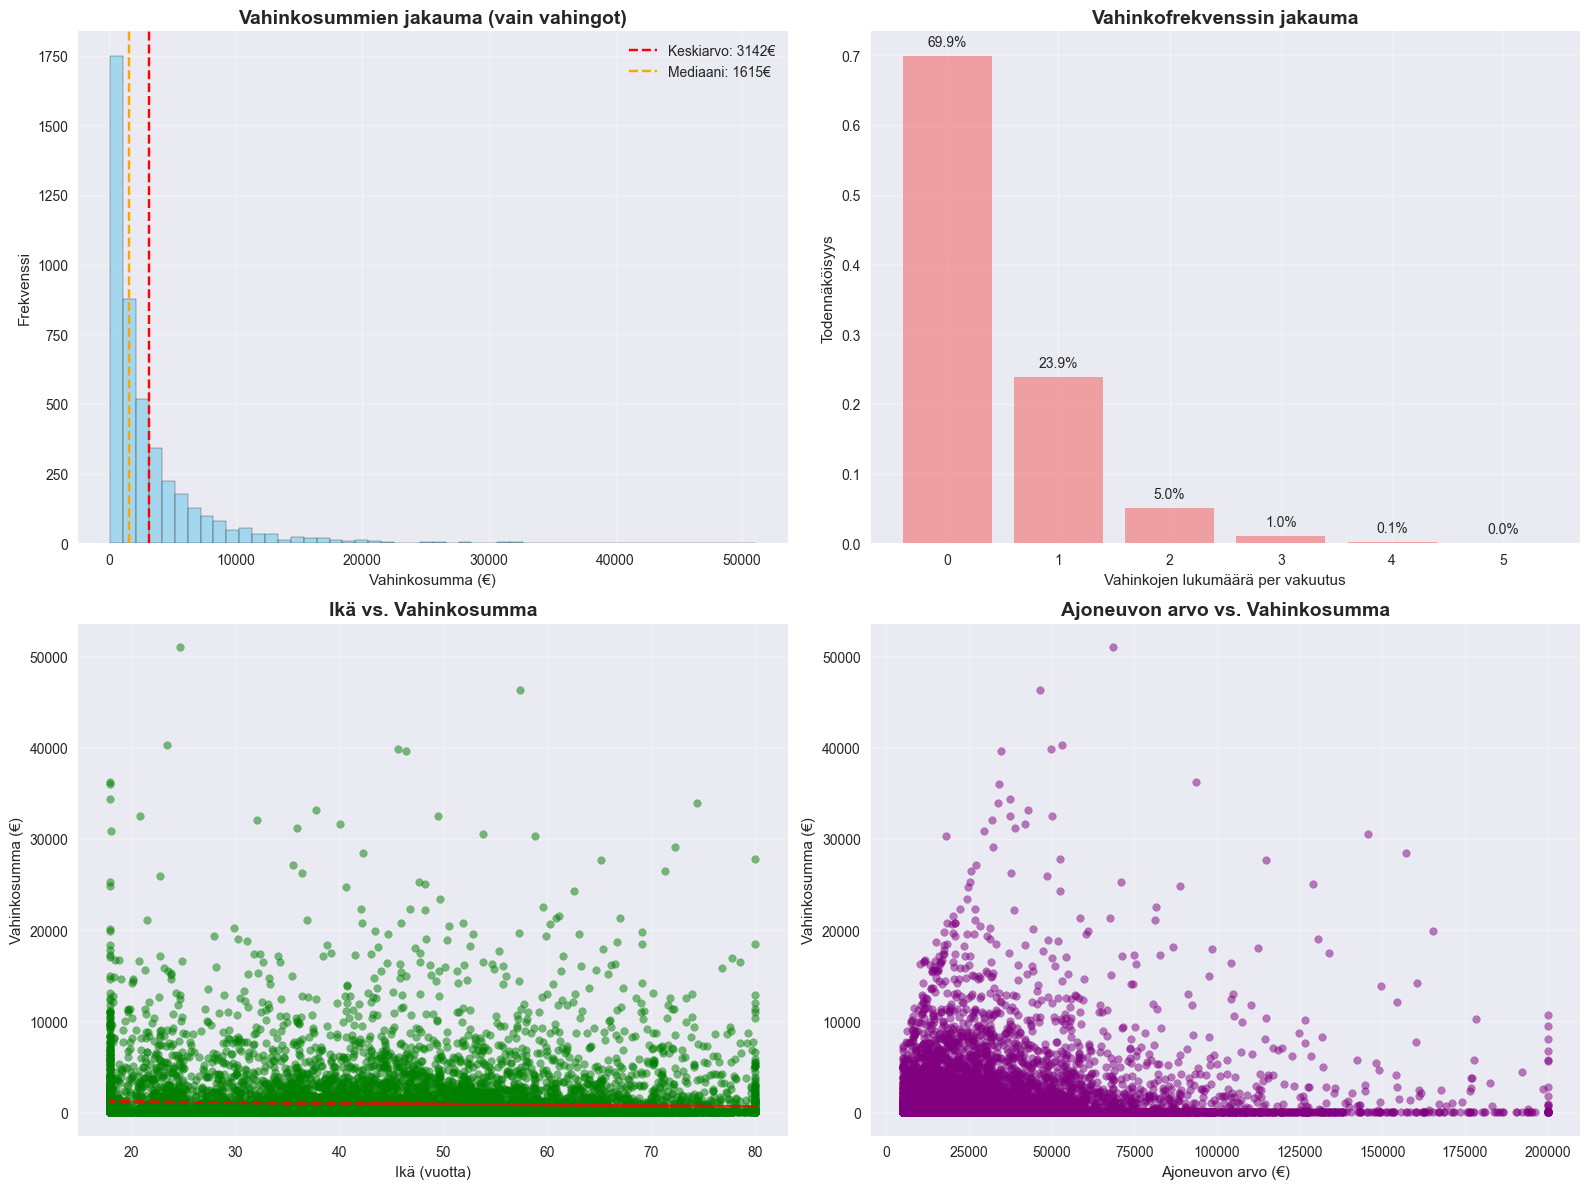


📊 Luodaan demografiset visualisoinnit...


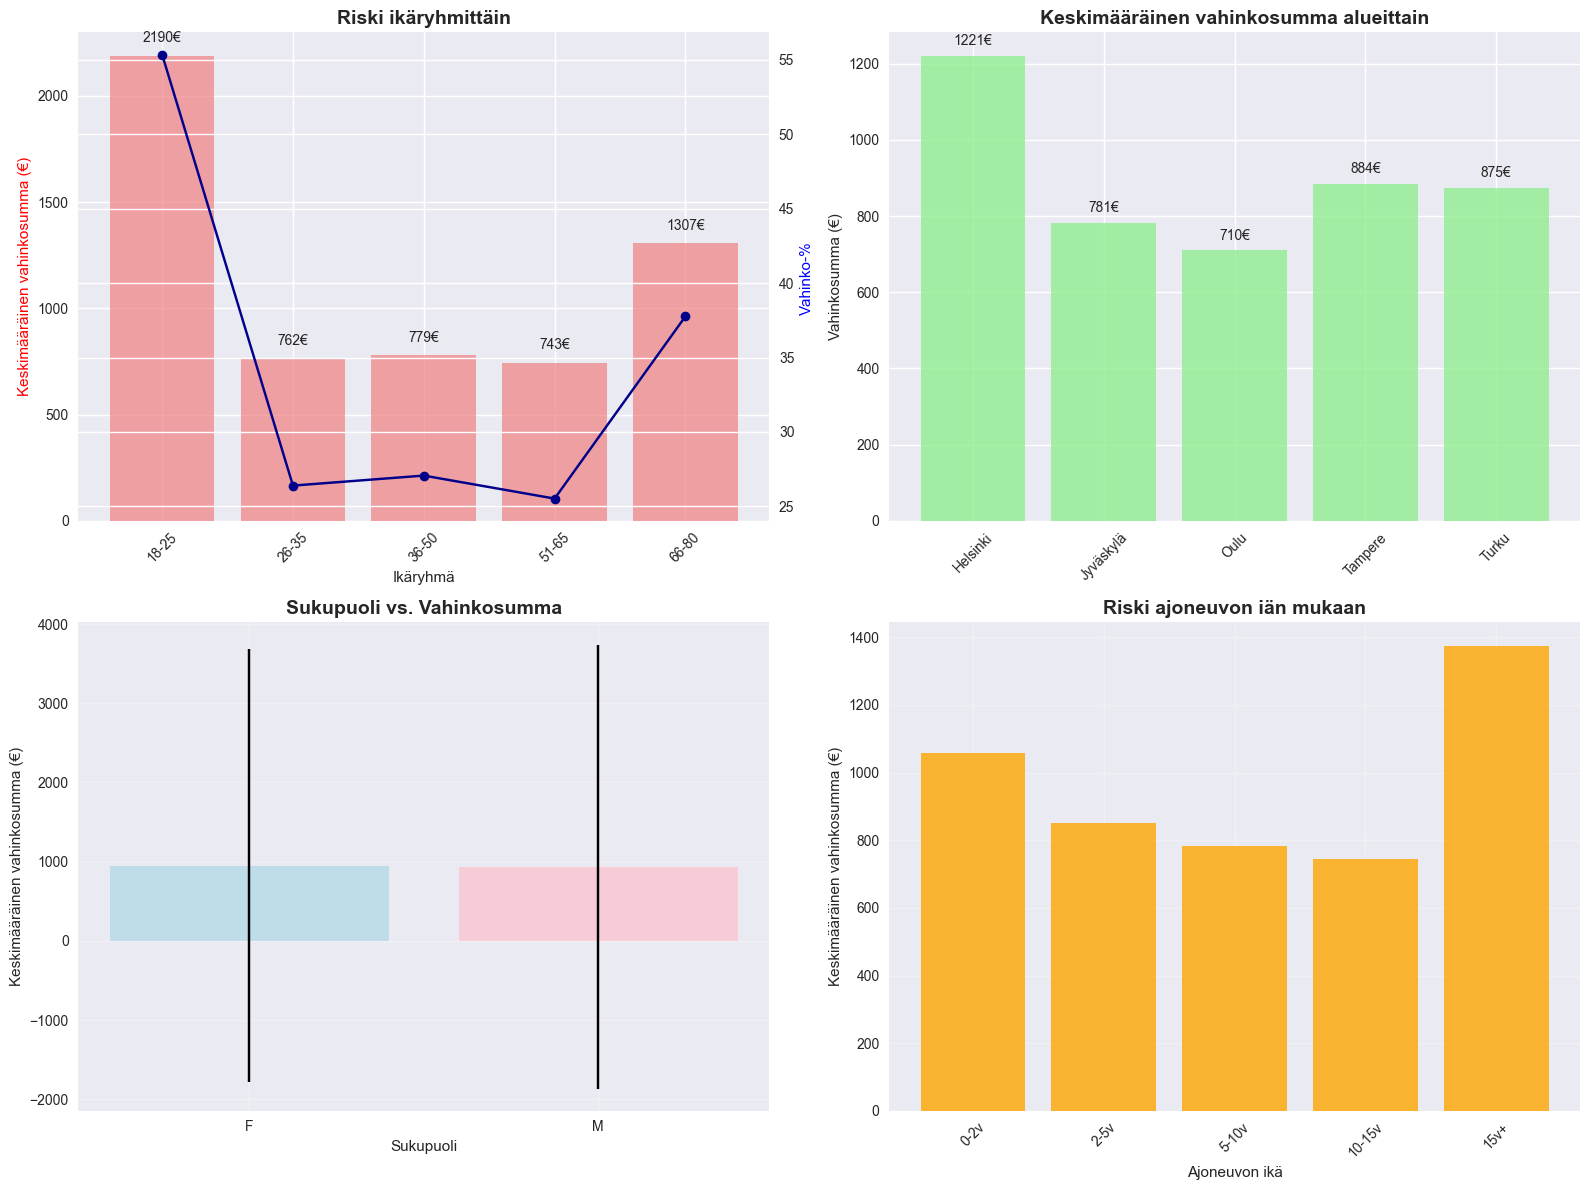

In [18]:
# Eksploratiivinen analyysi
print("\n🔄 VAIHE 2: Eksploratiivinen analyysi")
try:
    basic_stats = analyzer.exploratory_analysis()
    demographic_stats = analyzer.demographic_analysis()
    
    # Luodaan perusvisualisoinnit
    analyzer.create_basic_visualizations()
    analyzer.create_demographic_visualizations()
    
except Exception as e:
    print(f"❌ Virhe eksploratiivisessa analyysissä: {e}")

In [19]:
# Datan esikäsittely
print("\n🔄 VAIHE 3: Datan esikäsittely")
try:
    processed_data = analyzer.prepare_modeling_data()
    
    print(f"\n📊 Esikäsittelyn tulokset:")
    print(f"Features: {len(analyzer.feature_cols)}")
    print(f"Processed data shape: {processed_data.shape}")
    
except Exception as e:
    print(f"❌ Virhe datan esikäsittelyssä: {e}")


🔄 VAIHE 3: Datan esikäsittely

🔧 FEATURE ENGINEERING:
------------------------------
✅ Feature engineering valmis!
   Käytettävät featuret: 13
   Featuret: age, age_squared, gender_encoded, region_encoded, vehicle_age, vehicle_age_log, vehicle_value, annual_mileage, mileage_log, years_insured, previous_claims, experience_factor, value_per_age

📊 Esikäsittelyn tulokset:
Features: 13
Processed data shape: (15000, 22)


In [20]:
# Mallien kouluttaminen
print("\n🔄 VAIHE 4: Actuarial mallintaminen")
try:
    # 1. Vahinkofrekvenssi
    freq_results = analyzer.model_claim_frequency()
    
    # 2. Vahinkosuuruus  
    severity_results = analyzer.model_claim_severity()
    
    # 3. Kokonaisriski
    risk_results = analyzer.model_total_risk()
    
    print(f"\n✅ Kaikki mallit koulutettu onnistuneesti!")
    
except Exception as e:
    print(f"❌ Virhe mallien kouluttamisessa: {e}")


🔄 VAIHE 4: Actuarial mallintaminen

1️⃣ VAHINKOFREKVENSSIN MALLINTAMINEN (Poisson):
--------------------------------------------------
Train RMSE: 0.6389
Test RMSE: 0.6603
Mean actual frequency (test): 0.3790
Mean predicted frequency (test): 0.3743
Residuaalien keskiarvo: 0.0047
Residuaalien keskihajonta: 0.6604

2️⃣ VAHINKOSUURUUDEN MALLINTAMINEN (Random Forest):
--------------------------------------------------
📊 Mallinnusaineisto: 4509 vahinkotapausta
Train RMSE: 3188€
Test RMSE: 4940€
Train R²: 0.404
Test R²: 0.019
Mean actual severity (test): 3299€
Mean predicted severity (test): 3130€

3️⃣ KOKONAISRISKIN MALLINTAMINEN (Gradient Boosting):
--------------------------------------------------
Train RMSE: 1389€
Test RMSE: 3079€
Train R²: 0.736
Test R²: -0.037
Mean actual risk (test): 998€
Mean predicted risk (test): 986€

TOP 5 TÄRKEINTÄ RISKITEKIJÄÄ:
   vehicle_value       : 0.150
   value_per_age       : 0.142
   mileage_log         : 0.089
   age                 : 0.088
   annual


🔄 VAIHE 5: Hinnoitteluanalyysi

💰 HINNOITTELUANALYYSI:
----------------------------------------
RISKISEGMENTTI-ANALYYSI:
           Count  Actual_Mean  Actual_Std  Actual_Median  Predicted_Mean  \
Segment                                                                    
Very Low    2999        112.0       631.0            0.0           -82.0   
Low         3000        179.0       871.0            0.0           265.0   
Medium      3000        284.0      1084.0            0.0           542.0   
High        3000        623.0      1592.0            0.0           971.0   
Very High   2250       1958.0      3009.0         1179.0          1999.0   
Extreme      750       8227.0      6599.0         7029.0          6079.0   

           Predicted_Std  Claim_Rate  Suggested_Premium  \
Segment                                                   
Very Low           199.0         0.0             -114.8   
Low                 72.0         0.0              371.0   
Medium              93.0         

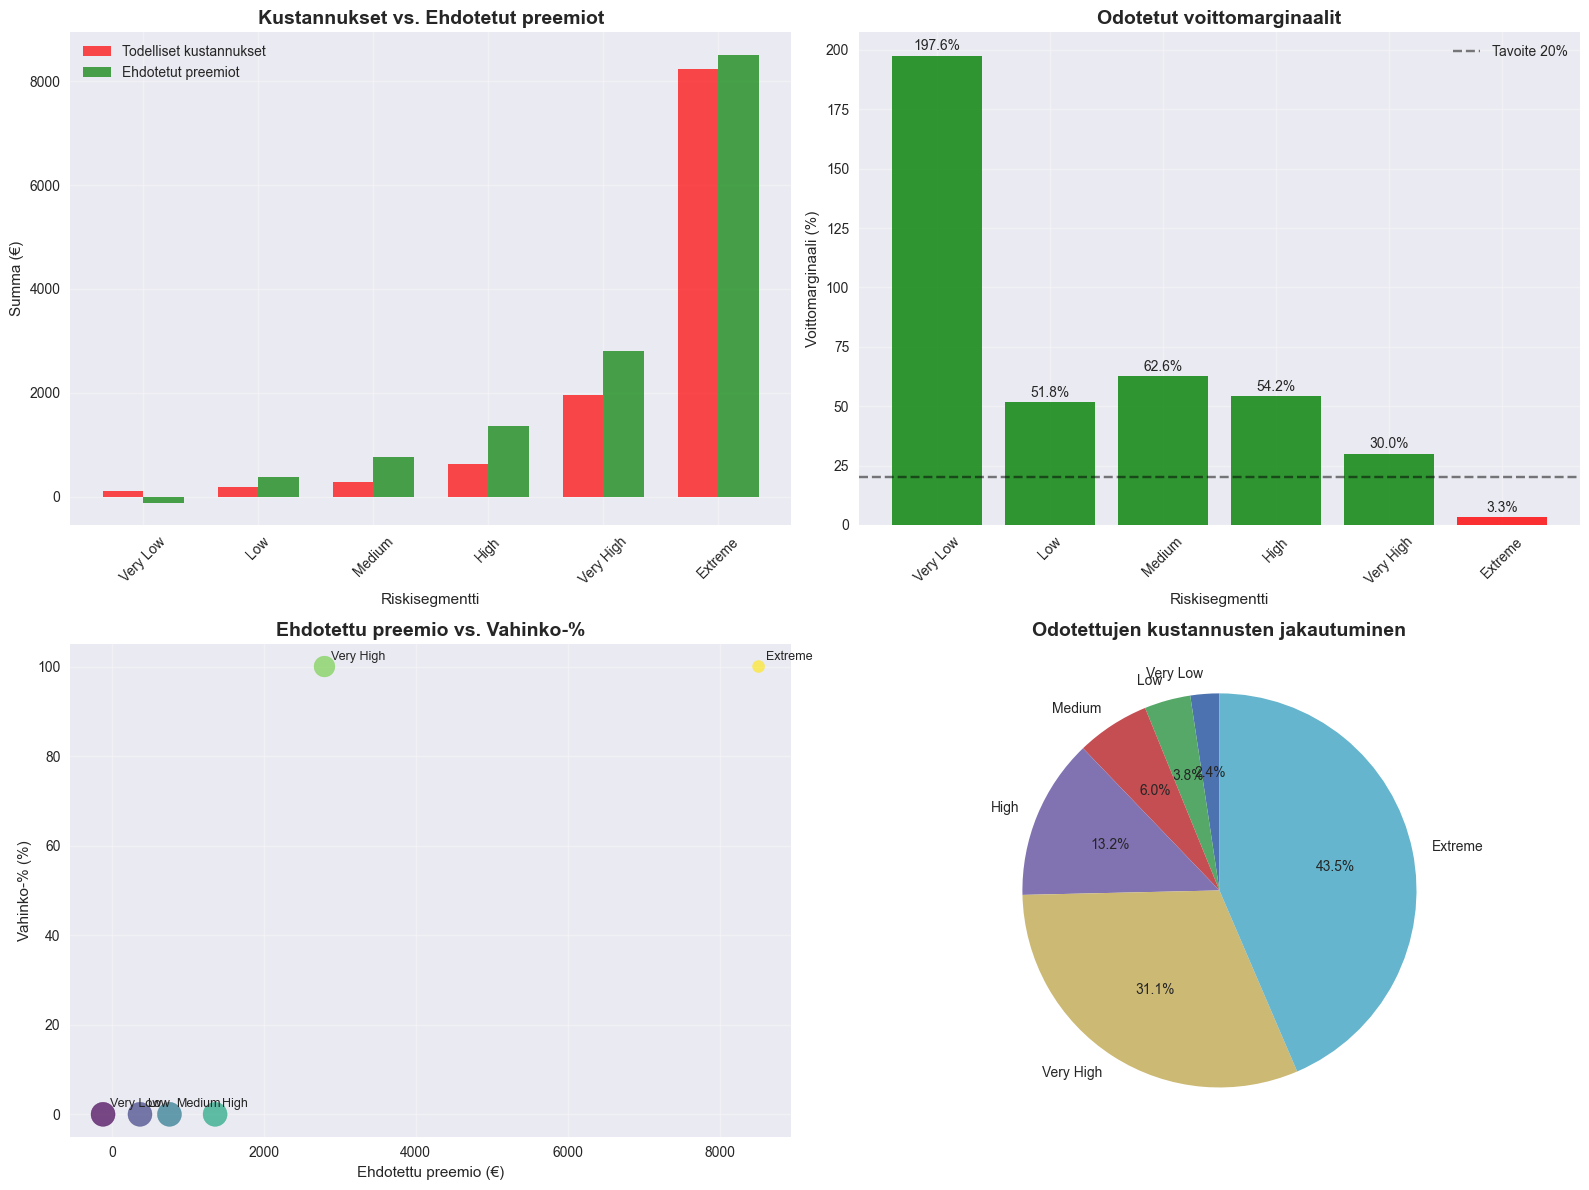


💰 HINNOITTELUN YHTEENVETO:
Kokonaistuotto (preemiot): 19,803,115€
Kokonaiskustannukset: 14,169,638€
Odotettu voitto: 5,633,477€
Kokonaismarginaali: 28.4%


In [21]:
# Hinnoitteluanalyysi
print("\n🔄 VAIHE 5: Hinnoitteluanalyysi")
try:
    pricing_results = analyzer.pricing_analysis()
    
    # Luo hinnoitteluvisualisoinnit
    analyzer.create_pricing_visualizations()
    
except Exception as e:
    print(f"❌ Virhe hinnoitteluanalyysissä: {e}")


🔄 VAIHE 6: Mallien suorituskyvyn analyysi

📊 Luodaan mallien suorituskyvyn visualisoinnit...


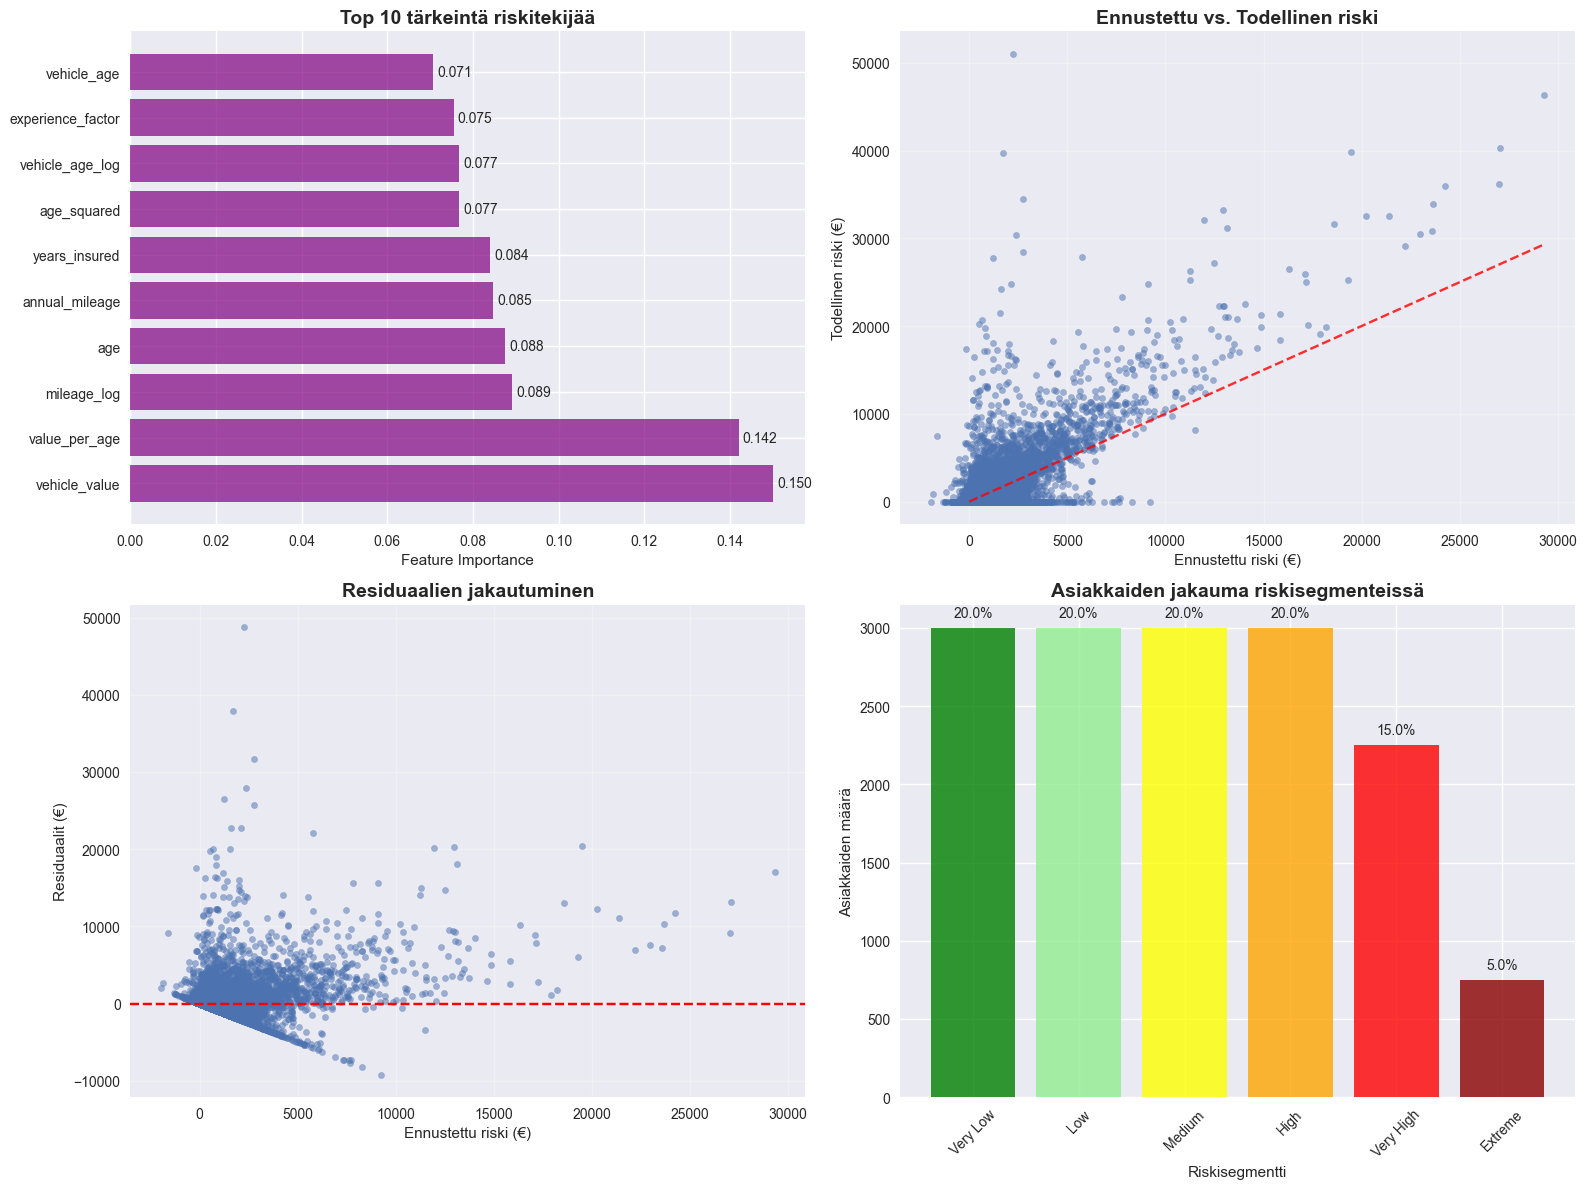

In [22]:
# Mallien suorituskyvyn visualisoinnit
print("\n🔄 VAIHE 6: Mallien suorituskyvyn analyysi")
try:
    analyzer.create_model_performance_visualizations()
    
except Exception as e:
    print(f"❌ Virhe suorituskyvyn analysoinnissa: {e}")

In [23]:
# Loppuraportti
print("\n🔄 VAIHE 7: Kattava loppuraportti")
try:
    final_report = analyzer.generate_comprehensive_report()
    
    print("\n✅ ANALYYSI VALMIS!")
    print("\nKESKEISET TULOKSET:")
    print(f"• Vahinkofrekvenssi: {final_report['claim_frequency']:.2%}")
    print(f"• Pure Premium: {final_report['pure_premium']:.0f}€")
    print(f"• Suositeltu preemio: {final_report['suggested_premium']:.0f}€")
    
except Exception as e:
    print(f"❌ Virhe raportin luomisessa: {e}")
    


🔄 VAIHE 7: Kattava loppuraportti

📋 VAKUUTUSRISKIN ANALYYSIRAPORTTI

📊 YLEISKATSAUS:
Analysoitu aineisto: 15,000 vakuutusta
Tarkastelujakso: 1 vuosi
Vakuutustyyppi: Autovakuutus

🔢 KESKEISET TUNNUSLUVUT:
Vahinkofrekvenssi: 30.06%
Keskimääräinen vahinkosuuruus: 3142€
Pure Premium: 945€

🤖 MALLIEN SUORITUSKYKY:
Kokonaisriskin RMSE: 1855€
Kokonaisriskin R²: 0.552
Keskimääräinen ennustevirhe: 894€

⚠️ RISKIANALYYSI:
Korkean riskin asiakkaita (top 10%): 1,500
Korkean riskin kynnys: 2826€
Maksimi vahinkosumma: 51029€

👥 DEMOGRAFISET HAVAINNOT:
Nuoret kuljettajat (<25v):
  - Osuus: 9.1%
  - Keskimääräinen riski: 2200€
  - Vahinko-%: 54.9%
Ikääntyneet kuljettajat (>65v):
  - Osuus: 9.3%
  - Keskimääräinen riski: 1307€
  - Vahinko-%: 37.8%

💰 HINNOITTELUSUOSITUKSET:
Suositeltu peruspreemio: 1322€
Loading factor: 40%
Odotettu voittomarginaali: 28.6%

📊 RISKISEGMENTOINTI:

Very Low RISKI:
  - Asiakkaita: 2999 (20.0%)
  - Keskimääräinen kustannus: 112€
  - Ehdotettu preemio: -115€
  - Odotettu ma

In [27]:
# Käytännön hinnoitteluesimerkit
print("\n💡 KÄYTÄNNÖN HINNOITTELUESIMERKIT:")
print("-" * 50)

if analyzer.risk_score_model is not None:
    # Määritellään esimerkkiasiakkaat
    examples = [
        {
            "name": "Nuori kuljettaja", 
            "age": 22, "gender": "M", "region": "Helsinki", 
            "vehicle_age": 1, "vehicle_value": 25000, "annual_mileage": 15000, 
            "years_insured": 1, "previous_claims": 0
        },
        {
            "name": "Kokenut kuljettaja", 
            "age": 45, "gender": "F", "region": "Turku",
            "vehicle_age": 5, "vehicle_value": 35000, "annual_mileage": 12000,
            "years_insured": 10, "previous_claims": 0
        },
        {
            "name": "Ikääntynyt kuljettaja", 
            "age": 68, "gender": "M", "region": "Oulu",
            "vehicle_age": 8, "vehicle_value": 20000, "annual_mileage": 8000,
            "years_insured": 25, "previous_claims": 1
        },
        {
            "name": "Korkean riskin kuljettaja", 
            "age": 21, "gender": "M", "region": "Helsinki",
            "vehicle_age": 0.5, "vehicle_value": 45000, "annual_mileage": 25000,
            "years_insured": 0.5, "previous_claims": 2
        }
    ]
    
    # Encoder mappings
    gender_map = {'M': 1, 'F': 0}
    region_map = {'Helsinki': 0, 'Tampere': 1, 'Turku': 2, 'Oulu': 3, 'Jyväskylä': 4}
    
    print("\n📋 ASIAKASKOHTAISET HINNOITTELUT:")
    print("=" * 70)
    
    for example in examples:
        # Luo feature vector
        features = np.array([[
            example['age'],
            example['age'] ** 2,
            gender_map[example['gender']],
            region_map[example['region']],
            example['vehicle_age'],
            np.log1p(example['vehicle_age']),
            example['vehicle_value'],
            example['annual_mileage'],
            np.log(example['annual_mileage']),
            example['years_insured'],
            example['previous_claims'],
            np.exp(-example['years_insured'] / 10),
            example['vehicle_value'] / (example['vehicle_age'] + 1)
        ]])
        
        # Ennustetaan riski
        predicted_cost = analyzer.risk_score_model.predict(features)[0]
        suggested_premium = predicted_cost * 1.4  # 40% loading
        
        # Määritellään riskikategoria
        if predicted_cost < 200:
            risk_cat = "Matala riski 🟢"
            discount = 0.9  # 10% alennus
        elif predicted_cost < 500:
            risk_cat = "Keskimääräinen riski 🟡"
            discount = 1.0  # Ei alennusta
        elif predicted_cost < 1000:
            risk_cat = "Kohonnut riski 🟠"
            discount = 1.1  # 10% korotus
        else:
            risk_cat = "Korkea riski 🔴"
            discount = 1.3  # 30% korotus
        
        final_premium = suggested_premium * discount
        
        print(f"\n👤 {example['name']}:")
        print(f"   📊 Profiilit: {example['age']}v, {example['gender']}, {example['region']}")
        print(f"   🚗 Ajoneuvo: {example['vehicle_age']:.1f}v vanha, arvo {example['vehicle_value']:,}€")
        print(f"   🛣️  Ajomäärä: {example['annual_mileage']:,} km/vuosi")
        print(f"   📈 Kokemus: {example['years_insured']:.1f} vuotta, {example['previous_claims']} aiempaa vahinkoa")
        print(f"   💰 Odotettu vahinkokustannus: {predicted_cost:.0f}€")
        print(f"   🏷️  Peruspreemio (40% loading): {suggested_premium:.0f}€")
        print(f"   🎯 Riskikategoria: {risk_cat}")
        print(f"   💵 LOPULLINEN PREEMIO: {final_premium:.0f}€")
        print(f"   📊 Odotettu voittomarginaali: {((final_premium - predicted_cost) / final_premium * 100):.1f}%")
        
else:
    print("❌ Malleja ei ole koulutettu! Suorita ensin mallintaminen.")



💡 KÄYTÄNNÖN HINNOITTELUESIMERKIT:
--------------------------------------------------

📋 ASIAKASKOHTAISET HINNOITTELUT:

👤 Nuori kuljettaja:
   📊 Profiilit: 22v, M, Helsinki
   🚗 Ajoneuvo: 1.0v vanha, arvo 25,000€
   🛣️  Ajomäärä: 15,000 km/vuosi
   📈 Kokemus: 1.0 vuotta, 0 aiempaa vahinkoa
   💰 Odotettu vahinkokustannus: 2656€
   🏷️  Peruspreemio (40% loading): 3718€
   🎯 Riskikategoria: Korkea riski 🔴
   💵 LOPULLINEN PREEMIO: 4834€
   📊 Odotettu voittomarginaali: 45.1%

👤 Kokenut kuljettaja:
   📊 Profiilit: 45v, F, Turku
   🚗 Ajoneuvo: 5.0v vanha, arvo 35,000€
   🛣️  Ajomäärä: 12,000 km/vuosi
   📈 Kokemus: 10.0 vuotta, 0 aiempaa vahinkoa
   💰 Odotettu vahinkokustannus: 172€
   🏷️  Peruspreemio (40% loading): 241€
   🎯 Riskikategoria: Matala riski 🟢
   💵 LOPULLINEN PREEMIO: 217€
   📊 Odotettu voittomarginaali: 20.6%

👤 Ikääntynyt kuljettaja:
   📊 Profiilit: 68v, M, Oulu
   🚗 Ajoneuvo: 8.0v vanha, arvo 20,000€
   🛣️  Ajomäärä: 8,000 km/vuosi
   📈 Kokemus: 25.0 vuotta, 1 aiempaa vahinko

In [26]:
# VALINNAINEN: Syvällisemmät analyysit

print("\n🔬 SYVÄLLISEMMÄT ANALYYSIT:")
print("-" * 40)

# 1. Katastrofiriskin simulointi
print("\n1. 📈 Katastrofiriskin simulointi:")
if analyzer.data is not None:
    # Simuloi "myrsky" -skenaario
    normal_claims = analyzer.data['total_claim_amount'].sum()
    
    # Oletetaan että 10% asiakkaista kokee 3x normaalin vahingon
    catastrophe_multiplier = 3
    affected_percentage = 0.1
    
    n_affected = int(len(analyzer.data) * affected_percentage)
    catastrophe_cost = analyzer.data.nlargest(n_affected, 'total_claim_amount')['total_claim_amount'].sum() * catastrophe_multiplier
    
    total_catastrophe_cost = normal_claims + catastrophe_cost
    catastrophe_increase = (total_catastrophe_cost / normal_claims - 1) * 100
    
    print(f"   Normaalit korvaukset: {normal_claims:,.0f}€")
    print(f"   Katastrofin lisäkustannus: {catastrophe_cost:,.0f}€")
    print(f"   Kokonaiskustannus: {total_catastrophe_cost:,.0f}€")
    print(f"   Kustannusten kasvu: {catastrophe_increase:.1f}%")

# 2. Asiakkaiden elinkaari-analyysi
print("\n2. 👥 Asiakkaiden elinkaari-analyysi:")
if analyzer.data is not None:
    # Asiakkaiden jakautuminen kokemuksen mukaan
    experience_groups = pd.cut(analyzer.data['years_insured'], 
                              bins=[0, 2, 5, 10, 30], 
                              labels=['Uusi (0-2v)', 'Nuori (2-5v)', 'Kokenut (5-10v)', 'Veteraani (10v+)'])
    
    lifecycle_analysis = analyzer.data.groupby(experience_groups).agg({
        'total_claim_amount': ['mean', 'count'],
        'has_claim': 'mean',
        'vehicle_value': 'mean'
    }).round(2)
    
    print("   Kokemusryhmien analyysi:")
    print(lifecycle_analysis)

# 3. Kilpailija-analyysi (simuloitu)
print("\n3. 🏆 Kilpailija-analyysi (simuloitu):")
if hasattr(analyzer, 'pricing_segments'):
    # Simuloi kilpailijoiden hintoja
    our_prices = analyzer.pricing_segments['Suggested_Premium']
    competitor_a_prices = our_prices * np.random.uniform(0.9, 1.1, len(our_prices))  # ±10%
    competitor_b_prices = our_prices * np.random.uniform(0.85, 1.15, len(our_prices))  # ±15%
    
    comparison = pd.DataFrame({
        'Segment': analyzer.pricing_segments.index,
        'Meidän_hinta': our_prices,
        'Kilpailija_A': competitor_a_prices,
        'Kilpailija_B': competitor_b_prices
    })
    
    comparison['Kilpailukyky_A'] = (comparison['Meidän_hinta'] < comparison['Kilpailija_A']).map({True: 'Parempi', False: 'Huonompi'})
    comparison['Kilpailukyky_B'] = (comparison['Meidän_hinta'] < comparison['Kilpailija_B']).map({True: 'Parempi', False: 'Huonompi'})
    
    print("   Hintavertailu kilpailijoihin:")
    print(comparison.round(0))

# 4. Reservin tarve (solvency)
print("\n4. 💼 Vakavaraisuuspääoman tarve:")
if analyzer.data is not None:
    # Yksinkertainen VaR-laskelma
    total_exposure = len(analyzer.data)
    annual_claims = analyzer.data['total_claim_amount'].sum()
    
    # 99.5% VaR (Solvency II -tyylinen)
    var_995 = np.percentile(analyzer.data['total_claim_amount'], 99.5)
    required_capital = var_995 * total_exposure * 0.1  # 10% puskuri
    
    print(f"   Vuosittainen korvauskulut: {annual_claims:,.0f}€")
    print(f"   99.5% VaR per vakuutus: {var_995:,.0f}€")
    print(f"   Arvioitu pääomantarve: {required_capital:,.0f}€")
    print(f"   Pääomantarve % liikevaihdosta: {required_capital/annual_claims*100:.1f}%")



🔬 SYVÄLLISEMMÄT ANALYYSIT:
----------------------------------------

1. 📈 Katastrofiriskin simulointi:
   Normaalit korvaukset: 14,169,065€
   Katastrofin lisäkustannus: 32,651,086€
   Kokonaiskustannus: 46,820,151€
   Kustannusten kasvu: 230.4%

2. 👥 Asiakkaiden elinkaari-analyysi:
   Kokemusryhmien analyysi:
                 total_claim_amount       has_claim vehicle_value
                               mean count      mean          mean
years_insured                                                    
Uusi (0-2v)                  887.63  4929      0.30      29312.49
Nuori (2-5v)                 968.08  4522      0.30      31278.05
Kokenut (5-10v)              963.51  3500      0.30      30763.14
Veteraani (10v+)             997.53  2049      0.31      31496.35

3. 🏆 Kilpailija-analyysi (simuloitu):
   Hintavertailu kilpailijoihin:
             Segment  Meidän_hinta  Kilpailija_A  Kilpailija_B Kilpailukyky_A  \
Segment                                                                 